###### 导入的库

In [1]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from glob import glob
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.models import * 

from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.initializers import RandomNormal

from keras.regularizers import l2
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError


2024-05-03 01:55:48.221931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 01:55:48.222076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 01:55:48.361688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0


数据处理

训练集数据表构建

In [23]:
#读取训练csv数据表
train_data=pd.read_csv('/kaggle/input/machine-learning-in-science-ii-2024/training_norm.csv')
#建立一个表里面有每BooleanDtype一个图片的id和对应的文件路径
train_dir='/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/'
train_data['Filepath'] = train_dir + train_data['image_id'].astype(str) + '.png'
train_data['speed']=train_data['speed'].astype(np.int64)
train_data['angle']=train_data['angle'].astype(np.float64)

In [24]:
train_data

,image_id,angle,speed,Filepath
0,1,0.4375,0,/kaggle/input/machine-learning-in-science-ii-2...
1,2,0.8125,1,/kaggle/input/machine-learning-in-science-ii-2...
2,3,0.4375,1,/kaggle/input/machine-learning-in-science-ii-2...
3,4,0.6250,1,/kaggle/input/machine-learning-in-science-ii-2...
4,5,0.5000,0,/kaggle/input/machine-learning-in-science-ii-2...
...,...,...,...,...
13788,13794,0.6250,1,/kaggle/input/machine-learning-in-science-ii-2...
13789,13795,0.4375,1,/kaggle/input/machine-learning-in-science-ii-2...
13790,13796,0.5625,0,/kaggle/input/machine-learning-in-science-ii-2...
13791,13797,0.6250,0,/kaggle/input/machine-learning-in-science-ii-2...


测试集数据表构建

In [25]:
#构建一个表用来存储测试数据
test_dir=Path('/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data/')
test_data=pd.DataFrame(list(test_dir.glob(r'**/*.png')),columns=['Filepath']).astype(str)
test_data['image_id'] = test_data['Filepath'].str.extract('\d+.*?(\d+)')
test_data['image_id']=test_data['image_id'].astype(np.int64)
test_data=test_data.sort_values(by='image_id')
test_data.reset_index(drop=True, inplace=True)
test_data['angle']=0
test_data['speed']=0
train_data['speed']=train_data['speed'].astype(np.int64)
train_data['angle']=train_data['angle'].astype(np.float64)

In [26]:
test_data

,Filepath,image_id,angle,speed
0,/kaggle/input/machine-learning-in-science-ii-2...,1,0,0
1,/kaggle/input/machine-learning-in-science-ii-2...,2,0,0
2,/kaggle/input/machine-learning-in-science-ii-2...,3,0,0
3,/kaggle/input/machine-learning-in-science-ii-2...,4,0,0
4,/kaggle/input/machine-learning-in-science-ii-2...,5,0,0
...,...,...,...,...
1015,/kaggle/input/machine-learning-in-science-ii-2...,1016,0,0
1016,/kaggle/input/machine-learning-in-science-ii-2...,1017,0,0
1017,/kaggle/input/machine-learning-in-science-ii-2...,1018,0,0
1018,/kaggle/input/machine-learning-in-science-ii-2...,1019,0,0


导入外部数据

In [28]:
external_data=pd.read_csv('/kaggle/input/external-csv/external.csv')
train_data=pd.concat([train_data,external_data],ignore_index=True)

测试图像显示功能

(-0.5, 319.5, 239.5, -0.5)

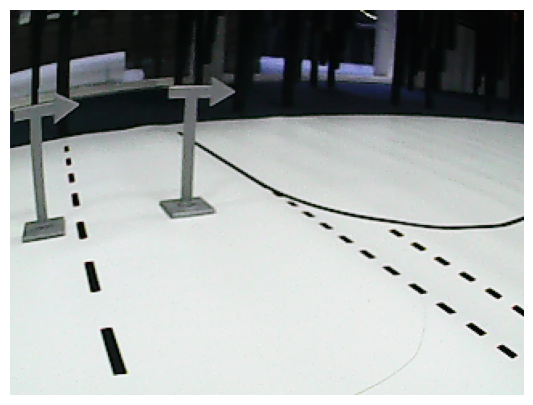

In [32]:
plt.figure(figsize=(15,5))
img=cv2.imread(train_data['Filepath'][127])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

在这里演示显示speed为1的图片

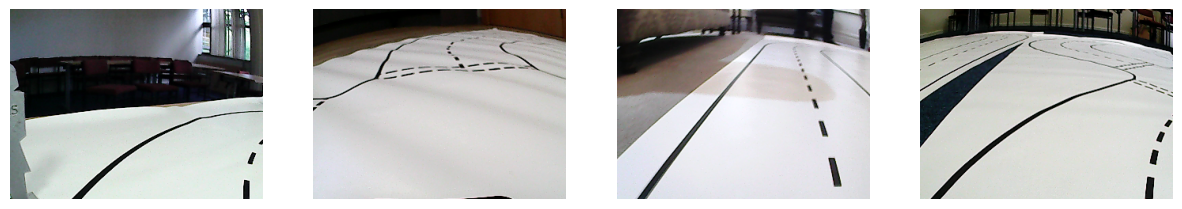

In [34]:
def sample_data(condition):
    sample = train_data[condition].sample(4).reset_index()
    plt.figure(figsize=(15, 5))

    for idx,pic in sample.iterrows():
        plt.subplot(1, 4, idx+1)
        img = cv2.imread(pic['Filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")

    plt.show()
sample_data(train_data['speed'] == 1)

data augmentation

在这里进行了数据增长，分为三个大类：
1. 随机阴影

因为偶尔会有阴影覆盖的轨迹，我们也必须训练我们的模型来识别它们。0.6-0.85

2. 左/右/上/下移动图像

为了对抗大量的中性角度，并为数据集提供更多的多样性，我们对图像进行随机移动，并在每个像素横向移动的方向上添加一个给定的偏移量。在我们的案例中，我们根据经验决定在每个像素向左或向右移动时增加(或减去)0.0035。向上/向下移动图像会使模型相信它在向上/向下倾斜。从实验中我们可以知道，这些侧向位移可能是使汽车正常驾驶所需的最重要的增长。

3. 变暗的图像

由于阴影或其他原因，轨道的某些部分变暗，我们还通过将所有RGB颜色通道乘以一个从范围中随机选取的标量，以使我们的一部分图像变暗。

In [35]:
#初始化数据增强类,在这里选择20%的数据作为验证集

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.15,
    )
'''# 随机阴影
    preprocessing_function=lambda img: img * np.random.uniform(0.6, 0.85),
    # 随机左右/上下移动图像
    '''

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



In [36]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col=['angle'],
    target_size=(100,100),
    color_mode='grayscale',
    class_mode='raw',
    batch_size= 16,
    shuffle=True,
    seed=42,
    subset='training'
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col=['angle'],
    target_size=(100,100),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)
    

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Filepath',
    y_col=['angle'],
    target_size=(100, 100),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=16,
    shuffle=False
)

Found 12342 validated image filenames.
Found 2177 validated image filenames.
Found 1020 validated image filenames.


In [37]:
val_images[0][0].shape

(16, 100, 100, 1)

查看数据增强的图片

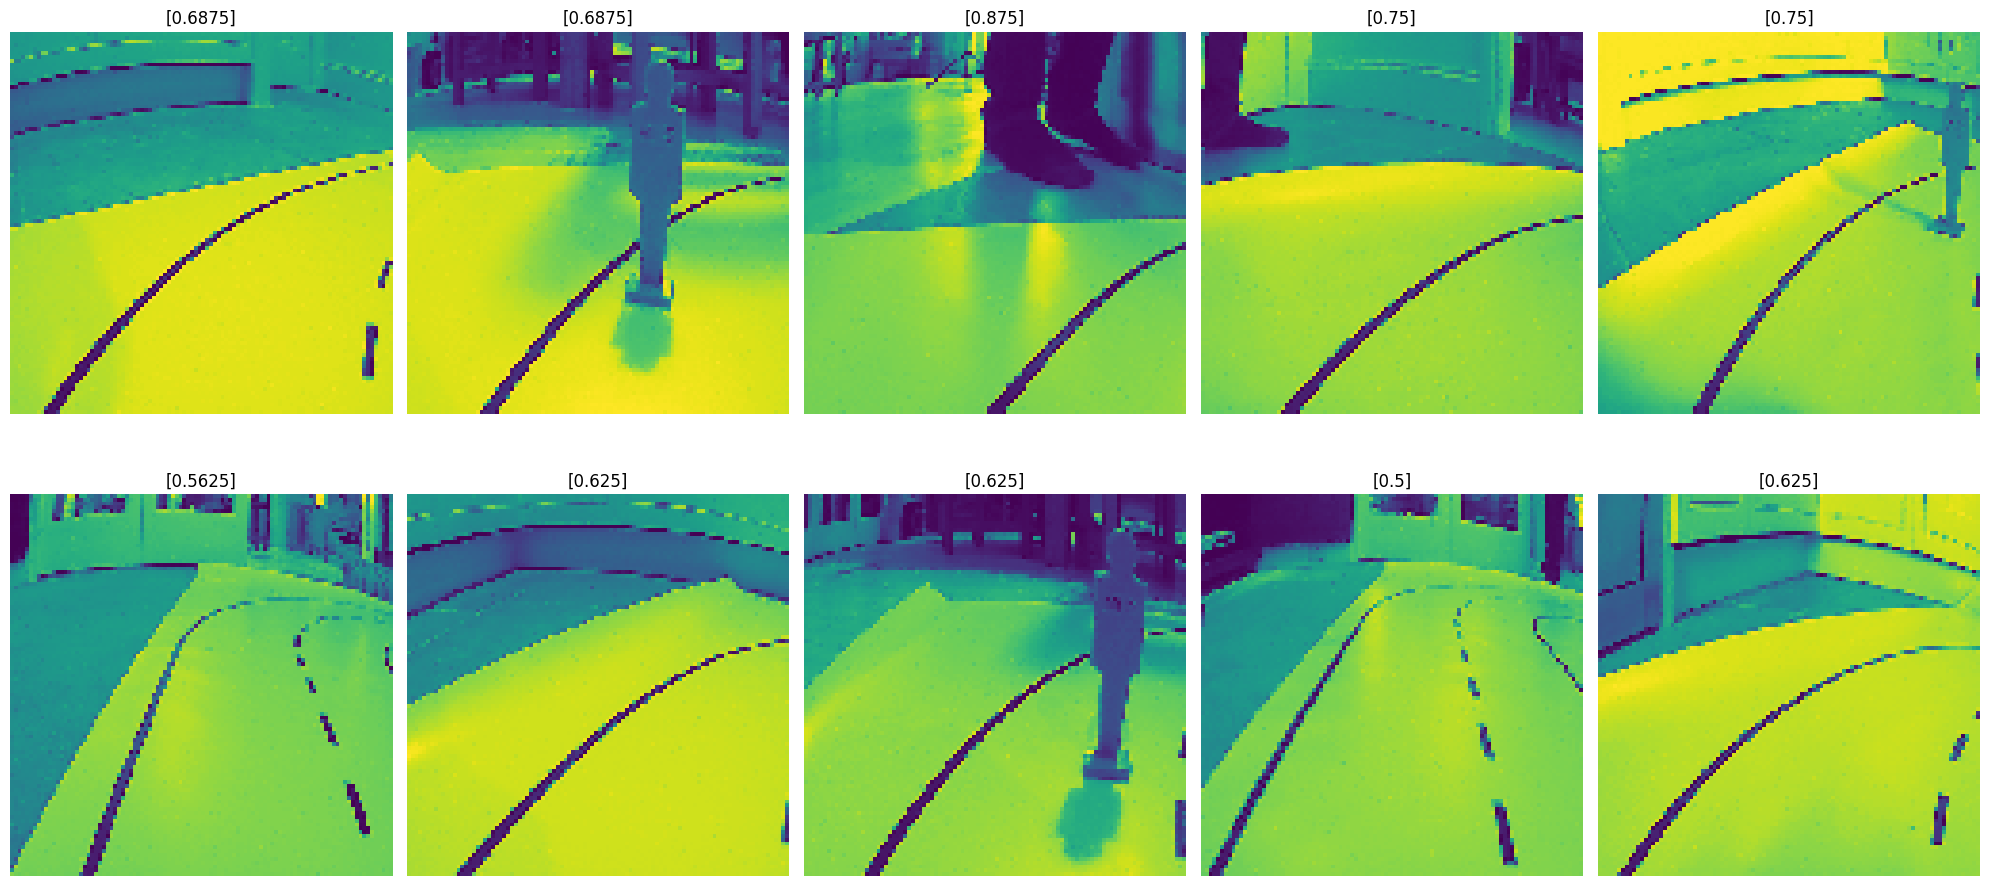

In [38]:
aug_images = [train_images[0][0][i] for i in range(14)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
i=0
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.set_title(train_images[0][1][i])
    i+=1
    ax.axis('off')
plt.tight_layout()
plt.show()

设置模型

实现了nvdia论文的模型https://cloud.tencent.com/developer/article/1673592

In [39]:
def elizabeth_model():
    model=Sequential(name='Elizabeth_Model')
    model.add(tf.keras.Input(shape=(100, 100, 1)))
    model.add(Convolution2D(32, (5, 5),padding='same',kernel_regularizer=l2(1e-6)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.35))

    model.add(Convolution2D(64, (5, 5),padding='same',kernel_regularizer=l2(1e-6)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.35))

    model.add(Convolution2D(64, 5, 5,padding='same',kernel_regularizer=l2(1e-6)))
   # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.35))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64,kernel_regularizer=l2(1e-6), kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

# the model so far outputs 3D feature maps (height, width, features)
    return model

指数衰减动态学习率

In [40]:
def create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps):
    decay_rate = (final_learning_rate / initial_learning_rate) ** (1. / total_decay_steps)
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=total_decay_steps,
        decay_rate=decay_rate,
        staircase=True)
    return learning_rate_schedule

编译模型

In [41]:
def compile_model_angle(model, initial_learning_rate, final_learning_rate, total_decay_steps):
    learning_rate_schedule = create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps)
    #使用Adam作为优化器，mse作为损失函数
    model.compile(
        optimizer = Adam(learning_rate=learning_rate_schedule),
        loss=MeanSquaredError()
    )
    return model

In [42]:
#编译模型用的参数
initial_learning_rate = 0.001
final_learning_rate = 0.0001
total_decay_steps = 200
# --------------------------------

model=elizabeth_model()
model.summary()

model = compile_model_angle(model,
                      initial_learning_rate,
                      final_learning_rate,
                      total_decay_steps)

Model: "Elizabeth_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      832       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 50, 50, 64)        0         
                                                   

训练模型

In [43]:

            
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "angle_best_model.keras",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )            

hist = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[early_stop,checkpoint]
)


Epoch 1/20


2024-05-03 02:12:48.457965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inElizabeth_Model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1714702371.640263     297 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


772/772 [==============================] - 177s 222ms/step - loss: 0.0143 - val_loss: 0.0094
Epoch 2/20
772/772 [==============================] - 66s 85ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 3/20
772/772 [==============================] - 66s 85ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 4/20
772/772 [==============================] - 64s 83ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 5/20
772/772 [==============================] - 65s 84ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 6/20
772/772 [==============================] - 64s 83ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 7/20
772/772 [==============================] - 64s 83ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 8/20
772/772 [==============================] - 62s 81ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/20
772/772 [==============================] - 63s 82ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 10/20
772/772 [==============================] - 63s 82ms/step - loss: 0.0075 - val_l

可视化训练过程中的loss

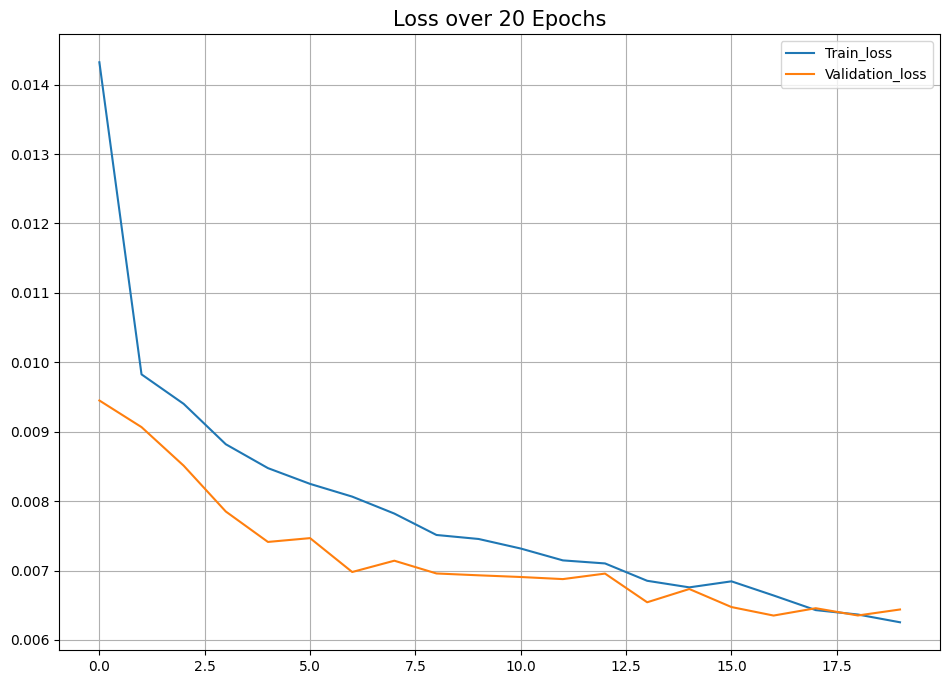

In [44]:
def plot_loss(result):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.figure(figsize=(25, 8))
    plt.subplot(122)
    plt.plot(range(0,len(loss)), loss[0:], label='Train_loss')
    plt.plot(range(0,len(loss)), val_loss[0:], label='Validation_loss')
    plt.title('Loss over ' + str(len(loss)) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(hist)


In [125]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# tflite_model.summary()

# #if tflite_model is None == 0:
# #    print("转换失败或者模型不可转换")
# #else:
# #    print("转换成功，tflite_model 不为空")

# with open('a.tflite', 'wb') as f:
#     f.write(tflite_model)

In [126]:
#'a.tflite'


保存模型

In [48]:
#model.save('angle_model.keras')
tf.keras.models.save_model(model,"/kaggle/working/angle_model")
#tf.keras.models.load_model("saved_model.pb")
#tf.saved_model.load("saved_model.pb")

In [55]:
!zip -r   angle_model.zip /kaggle/working/angle_model

updating: kaggle/working/angle_model/ (stored 0%)
  adding: kaggle/working/angle_model/variables/ (stored 0%)
  adding: kaggle/working/angle_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: kaggle/working/angle_model/variables/variables.index (deflated 63%)
  adding: kaggle/working/angle_model/assets/ (stored 0%)
  adding: kaggle/working/angle_model/keras_metadata.pb (deflated 92%)
  adding: kaggle/working/angle_model/saved_model.pb (deflated 88%)
  adding: kaggle/working/angle_model/fingerprint.pb (stored 0%)


进行预测

In [47]:
y_p=model.predict(test_images)
test_data['angle']=y_p
test_data.to_csv('angle.csv',index=False)

64/64 [==============================] - 11s 176ms/step
